In [65]:
#Packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [66]:
# Load the dataset
file_path = "AmazonDataSales.csv"

# Disable low_memory warning
pd.set_option('mode.chained_assignment', None)

# Read CSV with low_memory=False
df = pd.read_csv(file_path, low_memory=False)

# 1. Data Exploration

In [67]:
# Display the first few rows of the dataframe
df.head(2)

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN


### a) Förstå varje kolumn och dess datatyp

Datasetet har 4 olika datatyper. Boolean = binärt T/F, Float = decimaltal, Int64 = heltal, Object = textsträng

**Självklara kolumner:**
Index, Order ID, Date (DD-MM-ÅÅ), Sales Channel, ship-service-level, Style, Category, Size, Qty, currency, Amount, ship-city, ship-state, ship-postal-code, ship country, promotion-ids, fulfilled-by

Andra kolumner:
<br>**Status** (Grund status är Cancelled, Pending, Shipped, Shipping. Sedan finns underkategorier)
<br>**Fulfilment** (Either Amazon or Merchant)
<br>**SKU** (Stock Keeping Unit - identifier to keep track of inventory levels)
<br>**ASIN** (Amazon Standard Identification Number - indentifier)
<br>**Courier Status** (Någon sorts status i ett senare led)
<br>**B2B** (Business to Business flagga T/F)
<br>**Unnamed: 22** Oklart - innehåller många nullvärden - Tas bort


In [68]:
# Remove column Unnamed
columns_to_drop = ['Unnamed: 22']
df = df.drop(columns=columns_to_drop)

In [69]:
# Display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  Amount              121180 non-nul

In [70]:
# Display statistical overview of numerical columns
df.describe()

,index,Qty,Amount,ship-postal-code
count,128975.000000,128975.000000,121180.000000,128942.000000
mean,64487.000000,0.904431,648.561465,463966.236509
std,37232.019822,0.313354,281.211687,191476.764941
min,0.000000,0.000000,0.000000,110001.000000
25%,32243.500000,1.000000,449.000000,382421.000000
50%,64487.000000,1.000000,605.000000,500033.000000
75%,96730.500000,1.000000,788.000000,600024.000000
max,128974.000000,15.000000,5584.000000,989898.000000


### b) Unika värden, saknade data och potentiella fel

In [71]:
# Calculating the number of missing values in each column
# Funktionen nedan sammanställer "missing data" i alla eller viss kolumn.
# Den kan återanvändas för att dubbelkolla efter varje steg.

def missing_values_count(column):
    
    row_count = df.shape[0]
    
    if column == 'All':
    
        data = {'Column': [], 'Non-Null Count': [], 'Null Count': []}

        for column in df.columns:
            data['Column'].append(column)
            data['Non-Null Count'].append(df[column].count())
            data['Null Count'].append(row_count-df[column].count())

        info_df = pd.DataFrame(data)

        info_df['Percentage'] = (info_df['Null Count']/row_count*100).round(1)

        return info_df
    
    else:
        
        return row_count-df[column].count()

In [72]:
missing_values_count('All')

,Column,Non-Null Count,Null Count,Percentage
0,index,128975,0,0.0
1,Order ID,128975,0,0.0
2,Date,128975,0,0.0
3,Status,128975,0,0.0
4,Fulfilment,128975,0,0.0
5,Sales Channel,128975,0,0.0
6,ship-service-level,128975,0,0.0
7,Style,128975,0,0.0
8,SKU,128975,0,0.0
9,Category,128975,0,0.0


# 2. Data Cleaning

### a) Hantera saknade värden och datainkonsekvenser samt b) Standardisera textdata för enhetlighet

In [73]:
Column = 'Courier Status'

# Frequency list
print(f"Frequency list\n")
frequency_list = df[Column].value_counts()
print(frequency_list)
print(f"\nSum of frequencies: {frequency_list.sum()}")

# Unique values
unique = df[Column].unique()
print(f"Unique values: {len(unique)}\n")

# Check before
count = missing_values_count(Column)
print(f"Missing values before: {count}")

#Unique values
print(df[Column].unique())

# Replace missing values with unknown
df['Courier Status'] = df['Courier Status'].fillna('Unknown') 

# Check after
count = missing_values_count(Column)
print(f"Missing values after: {count}")

#Unique values
print(df[Column].unique())



Frequency list

Courier Status
Shipped      109487
Unshipped      6681
Cancelled      5935
Name: count, dtype: int64

Sum of frequencies: 122103
Unique values: 4

Missing values before: 6872
[nan 'Shipped' 'Cancelled' 'Unshipped']
Missing values after: 0
['Unknown' 'Shipped' 'Cancelled' 'Unshipped']


In [74]:
Column = 'currency'

# Frequency list
print(f"Frequency list\n")
frequency_list = df[Column].value_counts()
print(frequency_list)
print(f"\nSum of frequencies: {frequency_list.sum()}")

# Unique values
unique = df[Column].unique()
print(f"Unique values: {len(unique)}\n")

# Check before
count = missing_values_count(Column)
print(f"Missing values before: {count}")

#Unique values
print(df[Column].unique())

# Forward fill column values
df[Column] = df[Column].ffill()
print(f"\nMissing values was forward filled with INR\n")

# Check after
count = missing_values_count(Column)
print(f"Missing values after: {count}")

#Unique values
print(df[Column].unique())


Frequency list

currency
INR    121180
Name: count, dtype: int64

Sum of frequencies: 121180
Unique values: 2

Missing values before: 7795
['INR' nan]

Missing values was forward filled with INR

Missing values after: 0
['INR']


In [75]:
Column = 'Amount'

# Frequency list
print(f"Frequency list\n")
frequency_list = df[Column].value_counts()
print(frequency_list.head())
print(f"\nSum of frequencies: {frequency_list.sum()}")

# Unique values
unique = df[Column].unique()
print(f"Unique values: {len(unique)}\n")

# Max and Min values
column_stats = df[Column].describe()
max_value = column_stats.loc['max'].round(2)
min_value = column_stats.loc['min'].round(2)
print(f"Min and Max value: {min_value} and {max_value}\n")

# Check before
count = missing_values_count(Column)
print(f"Missing values before: {count}")

# Datatype
#df[Column].info() -- float64

# Mean value for column
mean_value = column_stats.loc['mean'].round(2)
print(f"Mean value before: {mean_value}\n")

# Fill nan with mean value
df[Column] = df[Column].fillna(mean_value)
print(f"Missing values were filled with mean value\n")

# Check after
count = missing_values_count(Column)
print(f"Missing values after: {count}")

# Mean value for column
column_stats = df[Column].describe()
mean_value = column_stats.loc['mean'].round(2)
print(f"Mean value after: {mean_value}")


Frequency list

Amount
399.0    5442
771.0    2797
735.0    2436
0.0      2343
487.0    2293
Name: count, dtype: int64

Sum of frequencies: 121180
Unique values: 1411

Min and Max value: 0.0 and 5584.0

Missing values before: 7795
Mean value before: 648.56

Missing values were filled with mean value

Missing values after: 0
Mean value after: 648.56


In [76]:
Column = 'ship-postal-code'

# Frequency list
print(f"Frequency list\n")
frequency_list = df[Column].value_counts()
print(frequency_list.head())
print(f"\nSum of frequencies: {frequency_list.sum()}")

# Unique values
unique = df[Column].unique()
print(f"Unique values: {len(unique)}\n")

# Check before
count = missing_values_count(Column)
print(f"Missing values before: {count}")

# df rows with missing postal code values
columns_to_display = ['ship-city','ship-country','ship-state','ship-postal-code']
#df[columns_to_display][df[Column].isna()]

# Datatype
#df[Column].info() -- float64
#df[Column].describe()  --max = 989898

# replace postal code 'nan' with 999999
df[Column] = df[Column].fillna('999999')

#Change datatype from float to string
df[Column] = df[Column].astype(str)
print(f"\nMissing values was filled with 999999 and data type was changed from float to string\n")

# Check after
count = missing_values_count(Column)
print(f"Missing values after: {count}")




Frequency list

ship-postal-code
201301.0    1006
122001.0     688
560037.0     632
560068.0     619
560076.0     581
Name: count, dtype: int64

Sum of frequencies: 128942
Unique values: 9460

Missing values before: 33

Missing values was filled with 999999 and data type was changed from float to string

Missing values after: 0


In [77]:
Column = 'ship-city'

# Frequency list
print(f"Frequency list\n")
frequency_list = df[Column].value_counts()
print(frequency_list.head())
print(f"\nSum of frequencies: {frequency_list.sum()}")

# Unique values
unique = df[Column].unique()
print(f"Unique values before cleaning: {len(unique)}\n")

# Check before
count = missing_values_count(Column)
print(f"Missing values before: {count}")

# fill na with unknown
df[Column] = df[Column].fillna('unknown')

# Check after
count = missing_values_count(Column)
print(f"Missing values after: {count}\n")

# Trim leading and ending spaces
df[Column] = df[Column].str.strip()

# Make lower case
df[Column] = df[Column].str.lower()

# Filter all cities with odd characters
pattern = r'[.-/ ,()\d]'
print(f"Rows contaning part of specified pattern {pattern}")
filtered_df = df[Column][df[Column].str.contains(pattern, na=False)]
patterns = filtered_df
print(patterns.head(5))
print(f"\nRow_count: {len(patterns)}")

# Clean city names from characters in pattern
df[Column] = df[Column].str.replace(pattern, '', regex=True)

# Unique values
unique = df[Column].unique()
print(f"Unique values after cleaning: {len(unique)}\n")




Frequency list

ship-city
BENGALURU    11217
HYDERABAD     8074
MUMBAI        6126
NEW DELHI     5795
CHENNAI       5421
Name: count, dtype: int64

Sum of frequencies: 128942
Unique values before cleaning: 8956

Missing values before: 33
Missing values after: 0

Rows contaning part of specified pattern [.-/ ,()\d]
2     navi mumbai
12      amravati.
17      new delhi
37      new delhi
38      new delhi
Name: ship-city, dtype: object

Row_count: 16501
Unique values after cleaning: 6941



In [78]:
Column = 'ship-state'

# Frequency list
print(f"Frequency list\n")
frequency_list = df[Column].value_counts()
print(frequency_list.head())
print(f"\nSum of frequencies: {frequency_list.sum()}")

# Unique values
unique = df[Column].unique()
print(f"Unique values: {len(unique)}\n")

# Check before
count = missing_values_count(Column)
print(f"Missing values before: {count}")

# fill na with unknown
df[Column] = df[Column].fillna('unknown')

# Check after
count = missing_values_count(Column)
print(f"Missing values after: {count}\n")

# Trim leading and ending spaces
df[Column] = df[Column].str.strip()

# Make lower case
df[Column] = df[Column].str.lower()

# Filter all cities with odd characters
# pattern from previous cell "ship-city"
print(f"\nRows contaning part of specified pattern {pattern}")
filtered_df = df[Column][df[Column].str.contains(pattern, na=False)]
patterns = filtered_df
print(patterns.head(5))
print(f"\nRow count: {len(patterns)}")

# Clean city names from characters in pattern
df[Column] = df[Column].str.replace(pattern, '', regex=True)

# Unique values
unique = df[Column].unique()
print(f"Unique values after cleaning: {len(unique)}\n")


Frequency list

ship-state
MAHARASHTRA      22260
KARNATAKA        17326
TAMIL NADU       11483
TELANGANA        11330
UTTAR PRADESH    10638
Name: count, dtype: int64

Sum of frequencies: 128942
Unique values: 70

Missing values before: 33
Missing values after: 0


Rows contaning part of specified pattern [.-/ ,()\d]
4        tamil nadu
5     uttar pradesh
9        tamil nadu
10       tamil nadu
11    uttar pradesh
Name: ship-state, dtype: object

Row count: 38088
Unique values after cleaning: 48



In [79]:
Column = 'ship-country'

# Frequency list
print(f"Frequency list\n")
frequency_list = df[Column].value_counts()
print(frequency_list)
print(f"\nSum of frequencies: {frequency_list.sum()}")

# Unique values
unique = df[Column].unique()
print(f"Unique values: {len(unique)}\n")

# Check before
count = missing_values_count(Column)
print(f"Missing values before: {count}")

# fill na with unknown
df[Column] = df[Column].fillna('unknown')

# Check after
count = missing_values_count(Column)
print(f"Missing values after: {count}")

# Trim leading and ending spaces
df[Column] = df[Column].str.strip()

# Make lower case
df[Column] = df[Column].str.lower()

# Filter all cities with odd characters
# pattern from previous cell "ship-city"
filtered_df = df[Column][df[Column].str.contains(pattern, na=False)]
patterns = filtered_df
print(patterns.head(5))
print(f"\nRows contaning part of specified pattern {pattern}: {len(patterns)}")

# Clean city names from characters in pattern
df[Column] = df[Column].str.replace(pattern, '', regex=True)

# Unique values
unique = df[Column].unique()
print(f"Unique values after cleaning: {len(unique)}\n")


Frequency list

ship-country
IN    128942
Name: count, dtype: int64

Sum of frequencies: 128942
Unique values: 2

Missing values before: 33
Missing values after: 0
Series([], Name: ship-country, dtype: object)

Rows contaning part of specified pattern [.-/ ,()\d]: 0
Unique values after cleaning: 2



In [80]:
Column = 'Category'

# Frequency list
print(f"Frequency list\n")
frequency_list = df[Column].value_counts()
print(frequency_list)
print(f"\nSum of frequencies: {frequency_list.sum()}")

# Unique values
unique = df[Column].unique()
print(f"Unique values: {len(unique)}\n")

# Check before
count = missing_values_count(Column)
print(f"Missing values before: {count}")

# fill na with unknown
df[Column] = df[Column].fillna('unknown')

# Check after
count = missing_values_count(Column)
print(f"Missing values after: {count}")



Frequency list

Category
Set              50284
kurta            49877
Western Dress    15500
Top              10622
Ethnic Dress      1159
Blouse             926
Bottom             440
Saree              164
Dupatta              3
Name: count, dtype: int64

Sum of frequencies: 128975
Unique values: 9

Missing values before: 0
Missing values after: 0


In [81]:
Column = 'Size'

# Frequency list
print(f"Frequency list\n")
frequency_list = df[Column].value_counts()
print(frequency_list)
print(f"\nSum of frequencies: {frequency_list.sum()}")

# Unique values
unique = df[Column].unique()
print(f"Unique values: {len(unique)}\n")

# Check before
count = missing_values_count(Column)
print(f"Missing values before: {count}")

# fill na with unknown
df[Column] = df[Column].fillna('unknown')

# Check after
count = missing_values_count(Column)
print(f"Missing values after: {count}")

Frequency list

Size
M       22711
L       22132
XL      20876
XXL     18096
S       17090
3XL     14816
XS      11161
6XL       738
5XL       550
4XL       427
Free      378
Name: count, dtype: int64

Sum of frequencies: 128975
Unique values: 11

Missing values before: 0
Missing values after: 0


In [82]:
Column = 'Qty'

# Frequency list
print(f"Frequency list\n")
frequency_list = df[Column].value_counts()
print(frequency_list)
print(f"\nSum of frequencies: {frequency_list.sum()}")

# Unique values
unique = df[Column].unique()
print(f"Unique values: {len(unique)}\n")

# Check before
count = missing_values_count(Column)
print(f"Missing values before: {count}")

# fill na with unknown
df[Column] = df[Column].fillna('unknown')

# Check after
count = missing_values_count(Column)
print(f"Missing values after: {count}")

Frequency list

Qty
1     115780
0      12807
2        341
3         32
4          9
5          2
15         1
9          1
13         1
8          1
Name: count, dtype: int64

Sum of frequencies: 128975
Unique values: 10

Missing values before: 0
Missing values after: 0


In [83]:
Column = 'Status'

# Frequency list
print(f"Frequency list\n")
frequency_list = df[Column].value_counts()
print(frequency_list)
print(f"\nSum of frequencies: {frequency_list.sum()}")

# Unique values
unique = df[Column].unique()
print(f"Unique values: {len(unique)}\n")

# Split Status to Status and Substatus

Column = ['Status','index']

df_part = df[Column]

df_part[['Status','Substatus']] = df_part['Status'].str.split(' - ', n=1, expand=True)

df_part = df_part[['index','Status','Substatus']]

# Frequency list Status - 4 unique values
frequency_list = df_part['Status'].value_counts()
print(frequency_list)
print(f"Sum of frequencies: {frequency_list.sum()}\n")

Frequency list

Status
Shipped                          77804
Shipped - Delivered to Buyer     28769
Cancelled                        18332
Shipped - Returned to Seller      1953
Shipped - Picked Up                973
Pending                            658
Pending - Waiting for Pick Up      281
Shipped - Returning to Seller      145
Shipped - Out for Delivery          35
Shipped - Rejected by Buyer         11
Shipping                             8
Shipped - Lost in Transit            5
Shipped - Damaged                    1
Name: count, dtype: int64

Sum of frequencies: 128975
Unique values: 13

Status
Shipped      109696
Cancelled     18332
Pending         939
Shipping          8
Name: count, dtype: int64
Sum of frequencies: 128975



### c) Konvertera Date till ett lämpligt format

In [84]:
# Date

Column = 'Date'

# Frequency list
frequency_list = df[Column].value_counts()
print(frequency_list)
print(f"\nSum of frequencies: {frequency_list.sum()}")

# Unique values
unique = df[Column].unique()
print(f"Unique values: {len(unique)}\n")

# Unique lengths
date_list = df[Column].to_list()
date_lengths = []
for i in date_list:
    date_lengths.append(len(i))
    
from collections import Counter

# Use Counter to create a frequency list
frequency_list = Counter(date_lengths)

# Check that all text strings have the same length
print("Frequency List string lengths:")
for item, count in frequency_list.items():
    print(f"{item}: {count}")

# Convert concatenated string to datetime format
df['Year'] = '20' + df[Column].str[6:8]
df['Month'] = df[Column].str[0:2]
df['Day'] = df[Column].str[3:5]

df['Date_conc'] = df['Year'] + df['Month'] + df['Day']

df[Column] = pd.to_datetime(df['Date_conc'], format='%Y%m%d')

# Drop temp column 'Date_conc'
columns_to_drop = ['Date_conc']
df = df.drop(columns=columns_to_drop)

columns_to_display = ['index','Date']
df_selected = df[columns_to_display]

df_selected

Date
05-03-22    2085
05-02-22    2079
05-04-22    2015
04-14-22    1883
04-15-22    1853
            ... 
06-23-22    1090
06-24-22    1028
06-25-22    1026
06-29-22     658
03-31-22     171
Name: count, Length: 91, dtype: int64

Sum of frequencies: 128975
Unique values: 91

Frequency List string lengths:
8: 128975


,index,Date
0,0,2022-04-30
1,1,2022-04-30
2,2,2022-04-30
3,3,2022-04-30
4,4,2022-04-30
...,...,...
128970,128970,2022-05-31
128971,128971,2022-05-31
128972,128972,2022-05-31
128973,128973,2022-05-31


# 3. Feature Engineering

### a) Derivera nya funktioner som Month, Year från Date

In [85]:
Column = 'Date'

df['Year'] = df[Column].dt.year
df['Month'] = df[Column].dt.month
df['Day'] = df[Column].dt.day

columns_to_display = ['index','Date', 'Year', 'Month', 'Day']

df_selected = df[columns_to_display]

df_selected.head()


,index,Date,Year,Month,Day
0,0,2022-04-30,2022,4,30
1,1,2022-04-30,2022,4,30
2,2,2022-04-30,2022,4,30
3,3,2022-04-30,2022,4,30
4,4,2022-04-30,2022,4,30


### b) Skapa binära funktioner från B2B

In [86]:
Column = 'B2B'

df[Column] = df[Column].replace(False, 0)
df[Column] = df[Column].replace(True, 1)

columns_to_show = ['index','Order ID', 'B2B']

df[columns_to_show].head()

,index,Order ID,B2B
0,0,405-8078784-5731545,0
1,1,171-9198151-1101146,0
2,2,404-0687676-7273146,1
3,3,403-9615377-8133951,0
4,4,407-1069790-7240320,0


### c) Gruppera Amount i olika försäljningsintervall

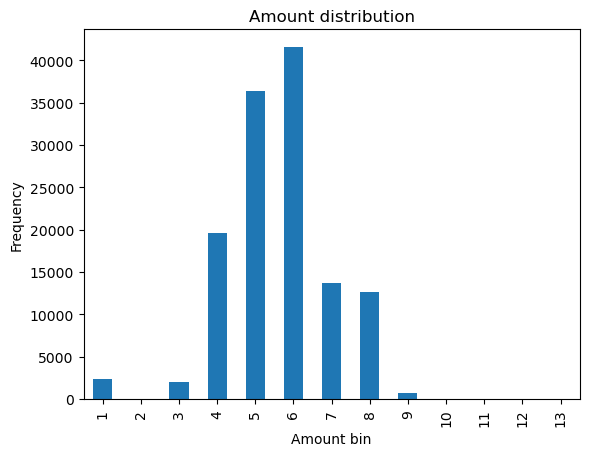

,amount_bin,description,count
0,1,< 100,2343
1,2,100-199,3
2,3,200-299,1960
3,4,300-399,19631
4,5,400-599,36426
5,6,600-799,41573
6,7,800-999,13706
7,8,1000-1499,12591
8,9,1500-1999,688
9,10,2000-2999,50


In [87]:
# Visualize Amount distribution

Column = 'Amount'

# Define bin edges and labels
bins = [0, 100, 200, 300, 400, 600, 800, 1000, 1500, 2000, 3000, 4000, 5000, 6000]
labels = [1,2,3,4,5,6,7,8,9,10,11,12,13]
desc = ['< 100','100-199','200-299','300-399','400-599','600-799','800-999','1000-1499','1500-1999','2000-2999','3000-3999','4000-4999','5000-5999']

df['Amount_int'] = pd.cut(df[Column], bins=bins, labels=labels, right=False)

frequency_list = df['Amount_int'].value_counts()

frequency_list_sorted = frequency_list.sort_index(ascending=True)

df_int = pd.DataFrame({'amount_bin': labels, 'description': desc, 'count': frequency_list_sorted.values})

columns_to_display = ['amount_bin', 'description', 'count']

# Plot a bar chart
df_int.plot(kind='bar', x='amount_bin', y='count', legend=False)
plt.title('Amount distribution')
plt.xlabel('Amount bin')
plt.ylabel('Frequency')
plt.show()

df_int = df_int[columns_to_display]
df_int

# 4. Data Transformation

### a) Normalisera numeriska värden i Amount och Qty

In [88]:
Columns = ['Amount','Qty']
df_to_scale = df[Columns]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data using MinMaxScaler
scaled_data = scaler.fit_transform(df[Columns])

# Create a new DataFrame with scaled data
scaled_df = pd.DataFrame(scaled_data, columns=df[Columns].columns)

# Display the original and scaled DataFrames
print("Original DataFrame:")
print(df_to_scale)
print("\nScaled DataFrame:")
print(scaled_df)


Original DataFrame:
         Amount  Qty
0        647.62    0
1        406.00    1
2        329.00    1
3        753.33    0
4        574.00    1
...         ...  ...
128970   517.00    1
128971   999.00    1
128972   690.00    1
128973  1199.00    1
128974   696.00    1

[128975 rows x 2 columns]

Scaled DataFrame:
          Amount       Qty
0       0.115978  0.000000
1       0.072708  0.066667
2       0.058918  0.066667
3       0.134909  0.000000
4       0.102794  0.066667
...          ...       ...
128970  0.092586  0.066667
128971  0.178904  0.066667
128972  0.123567  0.066667
128973  0.214721  0.066667
128974  0.124642  0.066667

[128975 rows x 2 columns]


### b) 'Status' one hot encoding

In [89]:
# Frequency list
frequency_list = df_part['Status'].value_counts()
print(frequency_list)
print(f"\nSum of frequencies: {frequency_list.sum()}")

# Applicera One hot encoding på Status

df_encoded = pd.get_dummies(df_part, columns=['Status'], prefix='Status')

columns_to_drop = ['Substatus'] 

df_encoded = df_encoded.drop(columns_to_drop, axis=1)

df_encoded.head(5)




Status
Shipped      109696
Cancelled     18332
Pending         939
Shipping          8
Name: count, dtype: int64

Sum of frequencies: 128975


,index,Status_Cancelled,Status_Pending,Status_Shipped,Status_Shipping
0,0,True,False,False,False
1,1,False,False,True,False
2,2,False,False,True,False
3,3,True,False,False,False
4,4,False,False,True,False
